<a href="https://colab.research.google.com/github/VladShajdulin/OTUS/blob/main/home_work_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import numpy as np

In [2]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else 'cpu'
print('Device', device)

Device cpu


# Обучение модели

In [3]:
low, high = -10, 10
n_size = 20000

torch.manual_seed(142)
X = (high - low) * torch.rand((n_size, 2), dtype=torch.float64) + low
y = torch.sin(X[:,0] + 2 * X[:,1]) * torch.exp(-(2 * X[:,0] + X[:,1]) ** 2)
y = torch.unsqueeze(y, -1)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=142)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=142)

print(f'Training samples: {X_train.size()[0]}')
print(f'Validating samples: {X_val.size()[0]}')
print(f'Training samples: {X_test.size()[0]}')

Training samples: 14000
Validating samples: 3000
Training samples: 3000


In [5]:
class XY_dataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return self.X.size()[0]

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

In [6]:
def train(dataloader, model, loss_fn, optimizer, device):
  size = len(dataloader.dataset)
  model.train()
  for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)

      # Compute prediction error
      pred = model(X)
      loss = loss_fn(pred, y)

      # Backpropagation
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      if batch % 20 == 0:
          loss, current = loss.item(), (batch + 1) * len(X)
          print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

  return loss.item()


def val(X, y, model, loss_fn):
  X, y = X.to(device), y.to(device)
  model.eval()
  with torch.no_grad():
    pred = model(X)
    loss = loss_fn(pred, y).item()
    error = max(abs(y - pred)).item() # Будем также считать макссимальное абсолютное отклонение

  print(f"\n Val loss: {loss:>7f}, max error: {error:>5f} \n")
  return loss

In [7]:
model_1 = nn.Sequential( # Сделаем простую полносвязную нейросеть
    nn.Linear(2, 20, dtype=torch.float64),
    nn.Softsign(), # Эта активация определена от -1 до 1 и "сгладит" LeakyReLU
    nn.Linear(20, 40, dtype=torch.float64),
    nn.LeakyReLU(), # Эта активация не затухает полностью ни на одном промежутке и может принимать любые значения
    nn.Linear(40, 20, dtype=torch.float64),
    nn.Softsign(),
    nn.Linear(20, 10, dtype=torch.float64),
    nn.LeakyReLU(),
    nn.Linear(10, 1, dtype=torch.float64)
)

In [8]:
batch_size = 64

train_loader = XY_dataset(X_train, y_train)
train_loader = DataLoader(train_loader, shuffle=True, batch_size=batch_size)
model_1.to(device)

Sequential(
  (0): Linear(in_features=2, out_features=20, bias=True)
  (1): Softsign()
  (2): Linear(in_features=20, out_features=40, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=40, out_features=20, bias=True)
  (5): Softsign()
  (6): Linear(in_features=20, out_features=10, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=10, out_features=1, bias=True)
)

In [9]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.AdamW(model_1.parameters())
epochs = 100
train_loss = []
val_loss = []


for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  t_l = train(train_loader, model_1, loss_fn, optimizer, device)
  v_l = val(X_val, y_val, model_1, loss_fn)
  train_loss.append(t_l)
  val_loss.append(v_l)

print("Done!")

Epoch 1
-------------------------------
loss: 0.016416  [   64/14000]
loss: 0.013122  [ 1344/14000]
loss: 0.025353  [ 2624/14000]
loss: 0.001289  [ 3904/14000]
loss: 0.037909  [ 5184/14000]
loss: 0.027783  [ 6464/14000]
loss: 0.005850  [ 7744/14000]
loss: 0.002127  [ 9024/14000]
loss: 0.039190  [10304/14000]
loss: 0.011963  [11584/14000]
loss: 0.017980  [12864/14000]

 Val loss: 0.015945, max error: 0.986892 

Epoch 2
-------------------------------
loss: 0.022503  [   64/14000]
loss: 0.004759  [ 1344/14000]
loss: 0.012888  [ 2624/14000]
loss: 0.024431  [ 3904/14000]
loss: 0.027481  [ 5184/14000]
loss: 0.014473  [ 6464/14000]
loss: 0.016829  [ 7744/14000]
loss: 0.022044  [ 9024/14000]
loss: 0.046938  [10304/14000]
loss: 0.006157  [11584/14000]
loss: 0.014035  [12864/14000]

 Val loss: 0.015603, max error: 1.012673 

Epoch 3
-------------------------------
loss: 0.006304  [   64/14000]
loss: 0.011206  [ 1344/14000]
loss: 0.023521  [ 2624/14000]
loss: 0.021795  [ 3904/14000]
loss: 0.0125

# Визуализация и оценка точности

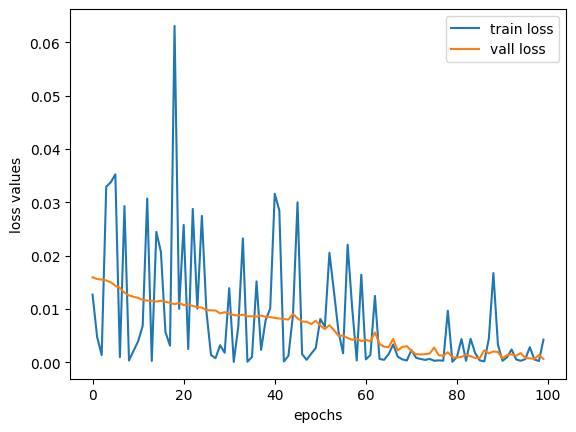

In [10]:
from matplotlib import legend
fig, axes = plt.subplots()
axes.plot(train_loss, label='train loss')
axes.plot(val_loss, label='vall loss')

axes.legend()
axes.set_ylabel('loss values')
axes.set_xlabel('epochs')

plt.show()

In [11]:
# Теперь оценим метрики на тестовых данных

val(X_test, y_test, model_1, nn.MSELoss())


 Val loss: 0.000603, max error: 0.318376 



0.0006034632658728311

In [12]:
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)
X, Y = np.meshgrid(x, y)
X, Y = torch.from_numpy(X), torch.from_numpy(Y)

X_grid = torch.stack([X, Y], dim=-1)
X_grid.size()

torch.Size([100, 100, 2])

In [13]:
model_1.eval()
with torch.no_grad():
  z = model_1(X_grid)

z = torch.squeeze(z)
z.shape

torch.Size([100, 100])

In [14]:
z_true = torch.sin(X_grid[:,:,0] + 2 * X_grid[:,:,1]) * torch.exp(-(2 * X_grid[:,:,0] + X_grid[:,:,1]) ** 2)
z_true.shape

torch.Size([100, 100])

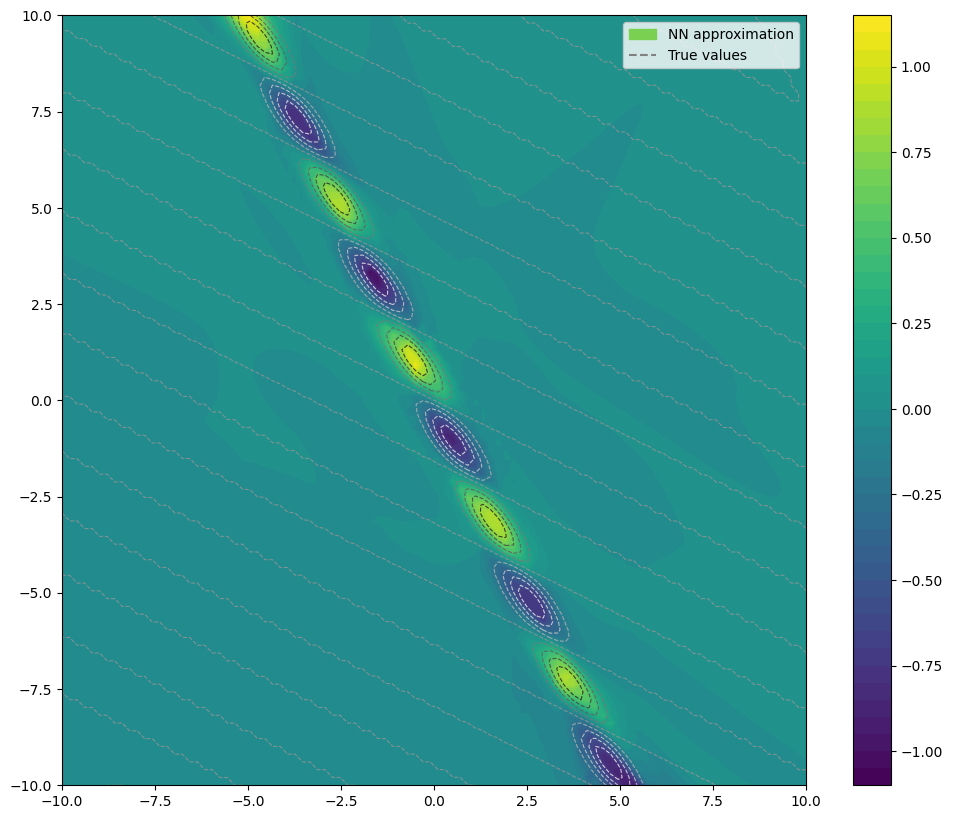

In [15]:
fig, ax = plt.subplots(figsize=(12, 10))

graph_1 = ax.contourf(X_grid[:,:,0], X_grid[:,:,1], z, 50,
                      cmap='viridis')
graph_2 = ax.contour(X_grid[:,:,0], X_grid[:,:,1], z_true, 12,
                     cmap='Greys',
                     linewidths=0.8,
                     linestyles='dashed',
                     alpha=0.8)

approx_patch = mpatches.Patch(color=plt.cm.viridis(0.8), label='NN approximation')
true_line = mlines.Line2D([], [], color='gray', linestyle='dashed', label='True values')
ax.legend(handles=[approx_patch, true_line])
plt.colorbar(graph_1, ax=ax)

plt.show()

Судя по визуализации аппроксимация хорошо повторяет как минимум форму исходной функции

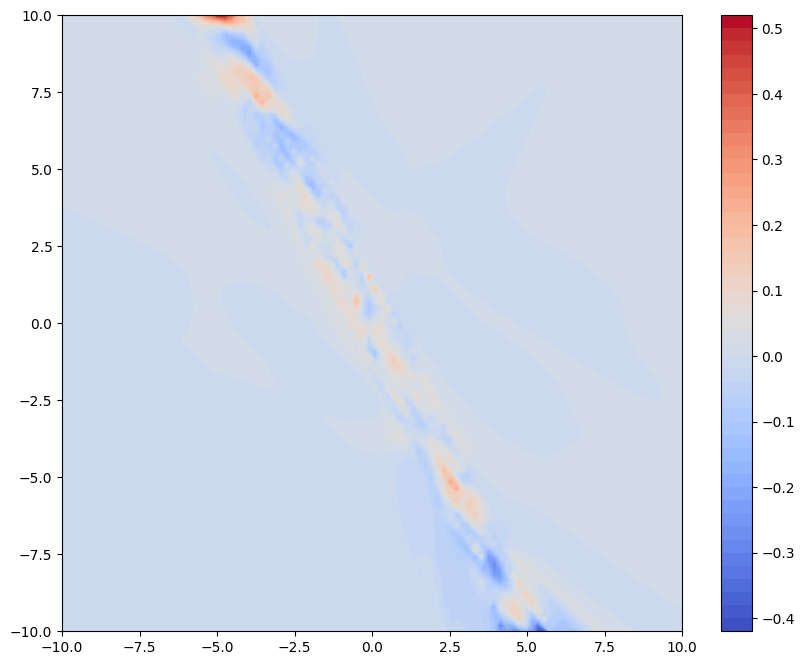

In [16]:
diff = z - z_true

fig, ax = plt.subplots(figsize=(10, 8))

graph_1 = ax.contourf(X_grid[:,:,0], X_grid[:,:,1], diff, 50,
            cmap='coolwarm')
plt.colorbar(graph_1, ax=ax)

plt.show()

Если нарисовать разность двух графиков, видно, что лишь на границе области отклонения до 0.5